In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix

In [4]:
def get_data(dataset):
  transform = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.Grayscale(1),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     #transforms.Normalize((0.5,), (0.5,), (0.5))
     ])

  #MNIST (60,000 train + 10,000 test)
  if dataset == 'MNIST':
    batch_size = 60000
    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False, num_workers=1)
    images_train, labels_train = next(iter(trainloader))

    batch_size = 10000
    testset = torchvision.datasets.MNIST(root='./data', train=False,
                                          download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=1)
    images_test, labels_test = next(iter(testloader))

    classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

  #FMNIST (60,000 train + 10,000 test)
  elif dataset == "FMNIST":
    batch_size = 10000 #60000
    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False, num_workers=1)
    images_train, labels_train = next(iter(trainloader))

    batch_size = 10000
    testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                          download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=1)
    images_test, labels_test = next(iter(testloader))

    classes = ('t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle-boot')

  data = {}
  data["train_images"] = images_train
  data["train_labels"] = labels_train

  data["test_images"] = images_test
  data["test_labels"] = labels_test

  dataloaders = {}
  dataloaders["train"] = trainloader
  dataloaders["test"] = testloader

  return data, dataloaders, classes

In [5]:
_, dataloaders, classes = get_data('FMNIST')
trainloader = dataloaders['train']
testloader = dataloaders['test']

#Modelo CNN

In [4]:
###Insert a CNN image to ilustrate the idea of CNNs

In [6]:
class basicCNN(nn.Module):
    def __init__(self):
        super(basicCNN, self).__init__()

        # Input: [batch_size, 1, 28, 28]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)  # Output: [batch_size, 32, 26, 26]
        self.relu = nn.ReLU()
        # Input: [batch_size, 32, 26, 26]
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) # Output: [batch_size, 64, 11, 11]

        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # Flattening: [batch_size, 64*5*5]
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Input: [batch_size, 1, 28, 28]
        x = F.relu(self.conv1(x))
        # Shape: [batch_size, 32, 26, 26]
        x = F.max_pool2d(x, 2)
        # Shape: [batch_size, 32, 13, 13]

        x = F.relu(self.conv2(x))
        # Shape: [batch_size, 64, 11, 11]
        x = F.max_pool2d(x, 2)
        # Shape: [batch_size, 64, 5, 5]

        #
        x = x.view(-1, 64 * 5 * 5) # Flattening
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model  = basicCNN().to(device)

#Optimizer and cirteria
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Number of complete passes through the dataset
num_epochs = 5

# Start the training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    # Iterate over each batch of the training data
    for images, labels in trainloader:
        # Move the images and labels to the computational device (CPU or GPU)
        images, labels = images.to(device), labels.to(device)

        # Clear the gradients from the previous iteration
        optimizer.zero_grad()

        # Forward pass: Pass the images through the model to get the predicted outputs
        outputs = model(images)

        # Compute the loss between the predicted outputs and the true labels
        loss = criterion(outputs, labels)

        # Backward pass: Compute the gradient of the loss w.r.t. model parameters
        loss.backward()

        # Update the model parameters
        optimizer.step()

    print(f"Epoch: {epoch} \t Loss: {loss}")

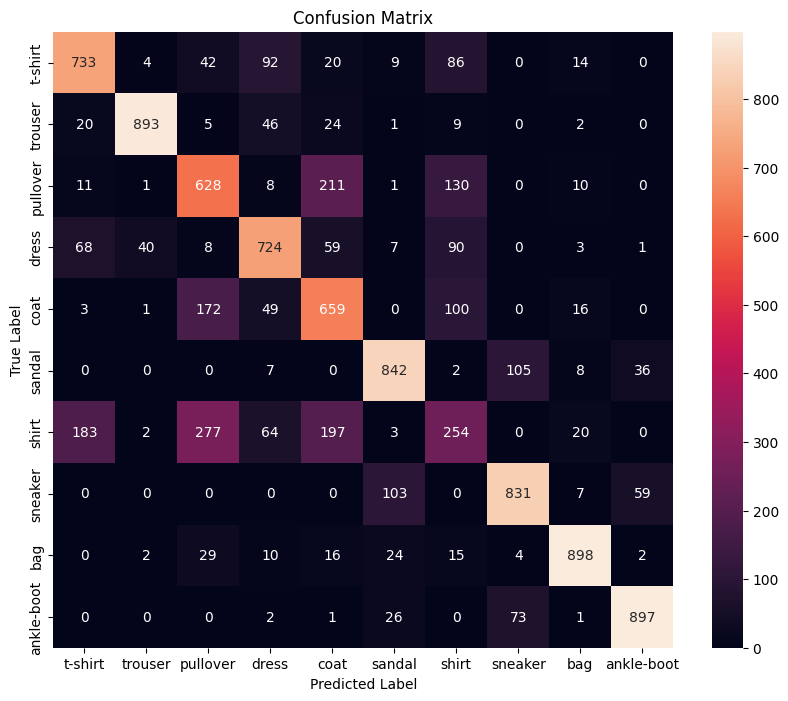

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the model to evaluation mode
model.eval()
_predicciones = []
_labels = []
with torch.no_grad():
  model = model.to(device)

  for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    _predicciones.extend(predicted.cpu().numpy())
    _labels.extend(labels.cpu().numpy())

#confusion matrix
cm = confusion_matrix(labels, _predicciones)
# Visualize the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d",# cmap=plt.cm.Heat,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')  # x-axis label
plt.ylabel('True Label')       # y-axis label
plt.title('Confusion Matrix')  # Title of the plot
plt.show()                     # Display the plot